In [1]:
import numpy as np
from casadi import *
import do_mpc

In [2]:
model_type = 'continuous'
model = do_mpc.model.Model(model_type)

In [3]:
#the model is configured with the following parameters:
m0 = 0.6 # kg, mass of the cart
m1 = 0.2 # kg, mass of the first rod
m2 = 0.2 # kg, mass of the second rod
L1 = 0.5 # m, length of the first rod
L2 = 0.5 # m, length of the second rod

g = 9.80665 # m/s^2, gravitational acceleration

In [4]:
# We furthermore introduce the following derived parameters to conveniently formulate the model equations below.

l1 = L1/2 # m,
l2 = L2/2 # m,
J1 = (m1 * l1**2) / 3   # Inertia
J2 = (m2 * l2**2) / 3   # Inertia

h1 = m0 + m1 + m2
h2 = m1*l1 + m2*L1
h3 = m2*l2
h4 = m1*l1**2 + m2*L1**2 + J1
h5 = m2*l2*L1
h6 = m2*l2**2 + J2
h7 = (m1*l1 + m2*L1) * g
h8 = m2*l2*g

In [5]:
# x = [x, theta1, theta2, dx, dtheta1, dtheta2]
# u = f

pos = model.set_variable('_x', 'pos')
theta = model.set_variable('_x', 'theta', (2,1))
dpos = model.set_variable('_x', 'dpos')
dtheta = model.set_variable('_x', 'dtheta', (2,1))

u = model.set_variable('_u', 'force')

In [6]:
# DIFFERENTIAL ALGEBRAIC EQUATION approach
ddpos = model.set_variable('_z', 'ddpos')
ddtheta = model.set_variable('_z', 'ddtheta', (2,1))

In [7]:
model.set_rhs('pos', dpos)
model.set_rhs('theta', dtheta)
model.set_rhs('dpos', ddpos)
model.set_rhs('dtheta', ddtheta)

In [8]:
euler_lagrange = vertcat(
        # 1
        h1*ddpos+h2*ddtheta[0]*cos(theta[0])+h3*ddtheta[1]*cos(theta[1])
        - (h2*dtheta[0]**2*sin(theta[0]) + h3*dtheta[1]**2*sin(theta[1]) + u),
        # 2
        h2*cos(theta[0])*ddpos + h4*ddtheta[0] + h5*cos(theta[0]-theta[1])*ddtheta[1]
        - (h7*sin(theta[0]) - h5*dtheta[1]**2*sin(theta[0]-theta[1])),
        # 3
        h3*cos(theta[1])*ddpos + h5*cos(theta[0]-theta[1])*ddtheta[0] + h6*ddtheta[1]
        - (h5*dtheta[0]**2*sin(theta[0]-theta[1]) + h8*sin(theta[1]))
    )

model.set_alg('euler_lagrange', euler_lagrange)
# Solves for ddpos and ddtheta and then finds the state variables

In [9]:
# Introduction of energy equations for the formulation of the MPC controller

E_kin_cart = 1 / 2 * m0 * dpos**2
E_kin_p1 = 1 / 2 * m1 * (
    (dpos + l1 * dtheta[0] * cos(theta[0]))**2 +
    (l1 * dtheta[0] * sin(theta[0]))**2) + 1 / 2 * J1 * dtheta[0]**2
E_kin_p2 = 1 / 2 * m2 * (
    (dpos + L1 * dtheta[0] * cos(theta[0]) + l2 * dtheta[1] * cos(theta[1]))**2 +
    (L1 * dtheta[0] * sin(theta[0]) + l2 * dtheta[1] * sin(theta[1]))**
    2) + 1 / 2 * J2 * dtheta[0]**2

E_kin = E_kin_cart + E_kin_p1 + E_kin_p2

E_pot = m1 * g * l1 * cos(
theta[0]) + m2 * g * (L1 * cos(theta[0]) +
                            l2 * cos(theta[1]))

model.set_expression('E_kin', E_kin)
model.set_expression('E_pot', E_pot)

SX(((0.490333*cos(theta_0))+(1.96133*((0.5*cos(theta_0))+(0.25*cos(theta_1))))))

In [10]:
# Build the model
model.setup()

In [11]:
mpc = do_mpc.controller.MPC(model)

In [12]:
setup_mpc = {
    'n_horizon': 100, # prediction horizion
    'n_robust': 0, # robust horizon
    'open_loop': 0, # if set to false, for each time step and scenario an individual control input it computed
    't_step': 0.04,  # timestep of the mpc
    'state_discretization': 'collocation', # state siscretization for continuous model (only collocation is available)
    'collocation_type': 'radau', # collocation type, only 'radau' is available
    'collocation_deg': 3, # collocation degree, defaults to 2
    'collocation_ni': 1, # number of finite elements for the states within a time-step (defauls to 1)
    'store_full_solution': True, # choose whether to store the full solution of the optimization problem
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

In [13]:
# Energy based formulation for the objective.
# We want to maximize the potential energy (up-up position)
# and minimize the kinetic energy (stabilization)

mterm = model.aux['E_kin'] - model.aux['E_pot'] # terminal cost
lterm = model.aux['E_kin'] - model.aux['E_pot'] # stage cost

mpc.set_objective(mterm = mterm, lterm = lterm)
# Input force is implicitly restricted through the objective
mpc.set_rterm(force = 0.1)


In [14]:
# set the constraints of the control problem
mpc.bounds['lower','_u','force'] = -4
mpc.bounds['upper','_u','force'] = 4

In [15]:
mpc.setup()

In [16]:
# We assume that all states can be directly measured
estimator = do_mpc.estimator.StateFeedback(model)

In [17]:
# Create simulator in order to run MPC in a closed-loop
simulator = do_mpc.simulator.Simulator(model)

In [18]:
params_simulator = {
    # Note: cvode doesn't support DAE systems
    'integration_tool': 'idas',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.04 # same time-step as the optimizer
}

simulator.set_param(**params_simulator)


In [19]:
simulator.setup()

In [20]:
# Define the initial state of the system and set for all parts of the closed-loop configuration:
simulator.x0['theta'] = 0.99*np.pi # exactly pi would give numerical issues

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

In [21]:
import matplotlib.pyplot as plt
plt.ion() # interactive mode on
from matplotlib import rcParams
rcParams['text.usetex'] = False
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['axes.labelsize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

In [22]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

In [23]:
def pendulum_bars(x):
    x = x.flatten()
    # Get the x,y coordinates of the 2 bars for the given state x
    line_1_x = np.array([
        x[0],
        x[0] + L1*np.sin(x[1])
    ])
    
    line_1_y = np.array([
        0,
        L1*np.cos(x[1])
    ])
    
    line_2_x = np.array([
        line_1_x[1],
        line_1_x[1] + L2*np.sin(x[2])
    ])
    
    line_2_y = np.array([
        line_1_y[1],
        line_1_y[1] + L2*np.cos(x[2])
    ])
    
    line_1 = np.stack((line_1_x, line_1_y))
    line_2 = np.stack((line_2_x, line_2_y))
    
    return line_1, line_2


In [24]:
%%capture

fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=4)
ax2 = plt.subplot2grid((4, 2), (0, 1))
ax3 = plt.subplot2grid((4, 2), (1, 1))
ax4 = plt.subplot2grid((4, 2), (2, 1))
ax5 = plt.subplot2grid((4, 2), (3, 1))

ax2.set_ylabel('$E_{kin}$ [J]')
ax3.set_ylabel('$E_{pot}$ [J]')
ax4.set_ylabel('Angle  [rad]')
ax5.set_ylabel('Input force [N]')

# Axis on the right.
for ax in [ax2, ax3, ax4, ax5]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax5:
        ax.xaxis.set_ticklabels([])

ax5.set_xlabel('time [s]')

mpc_graphics.add_line(var_type='_aux', var_name='E_kin', axis=ax2)
mpc_graphics.add_line(var_type='_aux', var_name='E_pot', axis=ax3)
mpc_graphics.add_line(var_type='_x', var_name='theta', axis=ax4)
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax5)

ax1.axhline(0,color='black')

bar1 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar2 = ax1.plot([],[], '-o', linewidth=5, markersize=10)

ax1.set_xlim(-1.8,1.8)
ax1.set_ylim(-1.2,1.2)
ax1.set_axis_off()

fig.align_ylabels()
fig.tight_layout()

In [25]:
u0 = mpc.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    19406
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6814

Total number of variables............................:     4330
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equa

  86  1.5147429e+02 6.56e-01 1.43e+00  -3.8 1.05e+02  -4.4 6.15e-01 1.00e+00h  1
  87  1.5070575e+02 9.51e-01 8.33e-01  -3.8 2.44e+02  -4.9 2.52e-01 3.27e-01h  1
  88  1.5012326e+02 9.13e-01 6.16e-01  -3.8 3.90e+02  -5.3 2.67e-01 1.43e-01h  1
  89  1.4964527e+02 6.11e-01 3.14e-01  -3.8 1.45e+02  -4.9 6.71e-01 3.51e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.4926662e+02 2.12e-01 2.62e-01  -3.8 5.61e+01  -4.5 1.00e+00 1.00e+00h  1
  91  1.4830872e+02 1.06e+00 1.73e+00  -3.8 2.77e+03  -5.0 5.84e-02 3.72e-02f  1
  92  1.4765534e+02 7.27e-01 1.03e+00  -3.8 1.61e+02  -4.5 7.51e-01 3.84e-01h  1
  93  1.4704069e+02 5.71e-01 3.99e-01  -3.8 1.65e+02  -5.0 9.13e-01 3.47e-01h  1
  94  1.4684500e+02 5.80e-01 3.94e-01  -3.8 1.24e+04  -5.5 4.19e-03 1.33e-03f  1
  95  1.4511124e+02 2.47e+00 1.30e+00  -3.8 2.38e+02  -5.1 3.44e-01 7.18e-01h  1
  96  1.4435072e+02 2.51e+00 1.81e+00  -3.8 2.38e+03  -4.6 1.67e-03 2.77e-02h  1
  97  1.4437950e+02 2.40e+00

 185  1.0236417e+02 1.84e-01 6.21e-01  -3.8 3.93e+01  -5.6 4.65e-01 5.45e-01h  1
 186  1.0236486e+02 1.62e-01 5.48e-01  -3.8 3.11e+01  -6.0 9.39e-01 1.19e-01h  1
 187  1.0242395e+02 2.32e-02 1.61e-01  -3.8 1.92e+01  -6.5 1.00e+00 1.00e+00h  1
 188  1.0246886e+02 9.59e-03 5.61e-02  -3.8 9.07e+00  -5.2 1.00e+00 1.00e+00h  1
 189  1.0242943e+02 5.54e-04 6.47e-03  -3.8 1.24e+00  -3.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  1.0242341e+02 5.10e-03 4.62e-02  -3.8 8.67e+00  -4.3 7.58e-01 5.00e-01h  2
 191  1.0239688e+02 4.02e-03 3.20e-02  -3.8 3.29e+00  -3.9 1.00e+00 1.00e+00h  1
 192  1.0236031e+02 2.15e-02 1.75e-01  -3.8 2.19e+01  -4.4 1.99e-01 5.00e-01h  2
 193  1.0224589e+02 2.35e-01 5.93e-01  -3.8 5.55e+01  -4.9 5.27e-02 9.62e-01h  1
 194  1.0182021e+02 4.58e-01 9.86e-01  -3.8 1.92e+02  -5.3 2.62e-01 3.02e-01h  1
 195  1.0167237e+02 3.26e-01 6.40e-01  -3.8 6.68e+01  -4.9 7.51e-01 3.00e-01h  1
 196  1.0144200e+02 5.83e-01

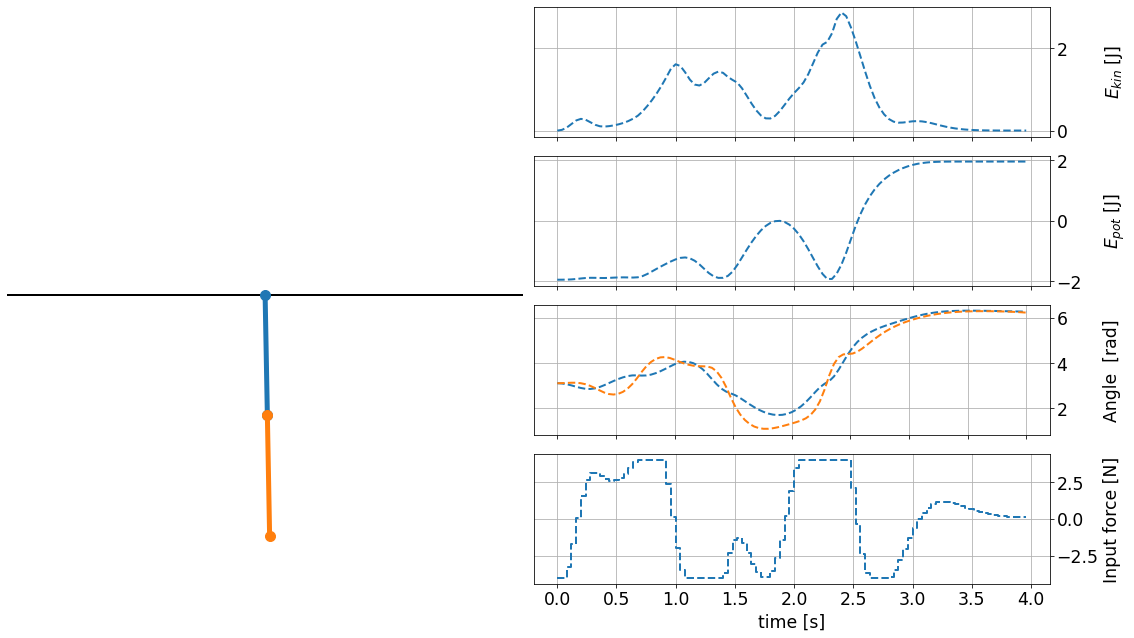

In [26]:
line1, line2 = pendulum_bars(x0)
bar1[0].set_data(line1[0],line1[1])
bar2[0].set_data(line2[0],line2[1])
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig

In [27]:
%%capture
# Quickly reset the history of the MPC data object.
mpc.reset_history()

n_steps = 50
for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

In [28]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

# The function describing the gif:
x_arr = mpc.data['_x']
def update(t_ind):
    line1, line2 = pendulum_bars(x_arr[t_ind])
    bar1[0].set_data(line1[0],line1[1])
    bar2[0].set_data(line2[0],line2[1])
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()


anim = FuncAnimation(fig, update, frames=n_steps, repeat=False)
gif_writer = ImageMagickWriter(fps=20)
anim.save('anim_dip.gif', writer=gif_writer)

In [29]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

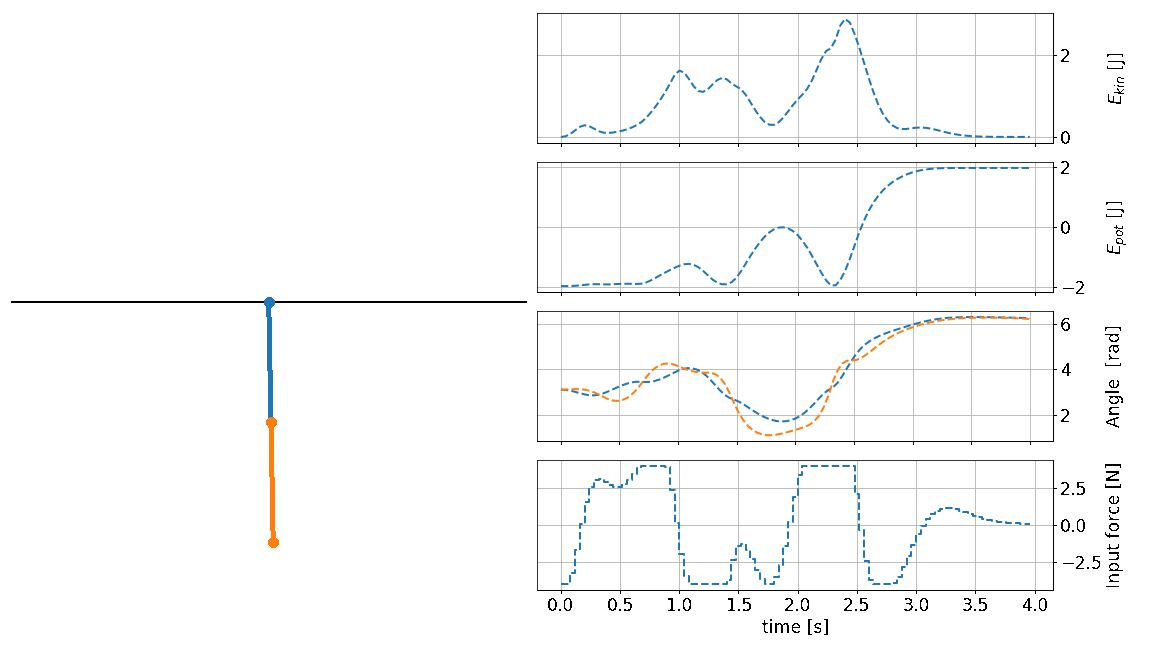

In [30]:
from pathlib import Path
gifPath = Path("./anim_dip.gif")
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')